# M3 Agentic AI - Turning functions into tools

## 1. Introduction

### 1.1. Lab overview

In this ungraded lab, you will create a set of tools with `aisuite` to give to an LLM. You will see how the LLM requests tools to be used and also the LLM choosing certain tools when relevant to its task.

### 🎯 1.2 Learning outcome

Apply tool-calling design patterns to agent workflows.

To achieve this you will give LLMs controlled access to python functions via AISuite, manage parameter passing and execution flow, and validate multi-step outputs generated through tool orchestration.


## 2. Setup: Initialize environment and client

As in previous labs, you will begin by initializing your environment. You will import several packages now and also later on as you build tools for your LLM.

In [1]:
import json
import display_functions
from dotenv import load_dotenv
_ = load_dotenv()

### 2.1 Getting started with AISuite

Next, you'll initialize the **AISuite** client that you've seen in previous lessons. Once initialized, this will be your interface for generating agent responses and calling tools.

Run the cell below to initialize the client.

In [2]:
import aisuite as ai

# Create an instance of the AISuite client
client = ai.Client()

## 3. Build your first tool

### 3.1 Defining your function

Now that you have set up your environment. It is time to create you first tool. Run the cell below to define a function that returns the current time as a string. Notice that this tool includes a docstring explanation of the functions purpose. This is important for `aisuite` because it will use this to help define the tool to the LLM.

In [3]:
from datetime import datetime

def get_current_time():
    """
    Returns the current time as a string.
    """
    return datetime.now().strftime("%H:%M:%S")

Test out your function to what exactly this function returns.

<div style="background-color:#ffe4e1; padding:12px; border-radius:6px; color:black;">
  <strong>Note:</strong> The DeepLearning.AI platform uses Greenwich Mean Time (GMT) by default. If you run this function locally, it will return your local time instead.
</div>

In [4]:
get_current_time()

'11:05:38'

Great! Just as expected, the function returns a string that has your current time.

### 3.2 Turning your function into an LLM tool

Now, let's use `aisuite` to pass this tool to an LLM and get a response. To set up your tool, you first set up the `response` from the LLM. Creating a response first requires creating the message structure. The message structure includes the prompt the user asks, as well as a dictionary that represents the conversation history and each message having a `role` (e.g., "user", "assistant", "system") and `content`.

In [5]:
# Message structure
prompt = "What time is it?"
messages = [
    {
        "role": "user",
        "content": prompt,
    }
]

After defining your message structure you can construct your chat completion. This will make the LLM call for you and return the result. Let's take a look at the parameters in this call.
* `model`: The model that will be used
* `messages`: The list of messages passed to the LLM
* `tools`: The list of tools that the LLM has access to
* `max_turns`: This is the maximum amount of messages the LLM will be allowed to make. This can help prevent the LLM from getting into infinite loops and repeatedly calling a tool.

Run the cell below to call the LLM and see the response.

In [6]:
response = client.chat.completions.create(
    model="openai:gpt-4o",
    messages=messages,
    tools=[get_current_time],
    max_turns=5
)

# See the LLM response
print(response.choices[0].message.content)

The current time is 11:05:42.


And just like that you've given your LLM access to tools! The `aisuite` tool turned your function into a tool that augmented the LLM's knowledge about the world.

### 3.3 Taking a closer look at the response
While the final response's content was just what was expected, there is actually a lot happening behind the scenes in the `response`. Let's use a helpful `utility` function to take a closer look. `pretty_print_chat_completion` will extract the steps from the response and show you the important parts in an easy to read format.

In [7]:
display_functions.pretty_print_chat_completion(response)

As you can see, the LLM sent a message to use `get_current_time`. This was executed on your machine and sent back to the LLM. Finally, the LLM, having the full conversation history, used that information to give the final response. `aisuite` handled all the complexities of pulling out the message with the tool call, executing it locally, and then passing the message back to the LLM when you used `max_turns` and passed the function name to the client.

### 3.4 Manually defining tools

You saw that the docstring provided by our tool helped `aisuite` automatically turn your function into a tool for the LLM. This is very convenient. But what is happening behind the scenes to take your function and make it a tool?

Actually, what the tool looks like to the LLM is more complicated. Let's take a look at how the LLM is *actually* given a tool below. Like before, tools are given in a list. But in that list, the tools have set schema that they expect. Within this schema are several important parts:
* `name`: The name of the corresponding function that you defined locally
* `description`: A description that explains what the function does and is used by the LLM to help it decide when to use it
* `parameters`: If your function has parameters, they would also be described with the parameter name and a description of what the parameter should be.

Run the cell below to define your tool using the schema.

In [8]:
tools = [{
    "type": "function",
    "function": {
        "name": "get_current_time", # <--- Your functions name
        "description": "Returns the current time as a string.", # <--- a description for the LLM
        "parameters": {}
    }
}]

In this case where you define a schema, `aisuite` expects you to handle the execution. So you will not use `max_turns`, and instead handle the execution yourself. Let's set this up by defining the response.

In [9]:
response = client.chat.completions.create(
    model="openai:gpt-4o",
    messages=messages,
    tools=tools, # <-- Your list of tools with get_current_time
    # max_turns=5 # <-- When defining tools manually, you must handle calls yourself and cannot use max_turns
)

Now you can take a look at the response from the LLM.

In [10]:
print(json.dumps(response.model_dump(), indent=2, default=str))

{
  "id": "chatcmpl-CZBlbLSJWZ3dYBgtVSWA36Hbwf440",
  "choices": [
    {
      "finish_reason": "tool_calls",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": null,
        "refusal": null,
        "role": "assistant",
        "annotations": [],
        "audio": null,
        "function_call": null,
        "tool_calls": [
          {
            "id": "call_5wrcFdsTXI0uEUlZZx3mjUPv",
            "function": {
              "arguments": "{}",
              "name": "get_current_time"
            },
            "type": "function"
          }
        ]
      }
    }
  ],
  "created": 1762502747,
  "model": "gpt-4o-2024-08-06",
  "object": "chat.completion",
  "service_tier": "default",
  "system_fingerprint": "fp_b1442291a8",
  "usage": {
    "completion_tokens": 11,
    "prompt_tokens": 45,
    "total_tokens": 56,
    "completion_tokens_details": {
      "accepted_prediction_tokens": 0,
      "audio_tokens": 0,
      "reasoning_tokens": 0,
      "rejected_pr

Notice that in the `response` you can see `tool_calls` under `message`. This response from the LLM is saying that the LLM now wants to call a tool, specifically, `get_current_time`. You can add some logic to handle this situation. Then pass that back to the model and get the final response.

Run the cell below to run the function locally and return it to the LLM and receive the final response.

In [11]:
response2 = None

# Create a condition in case tool_calls is in response object
if response.choices[0].message.tool_calls:
    # Pull out the specific tool metadata from the response
    tool_call = response.choices[0].message.tool_calls[0]
    args = json.loads(tool_call.function.arguments)

    # Run the tool locally
    tool_result = get_current_time()

    # Append the result to the messages list
    messages.append(response.choices[0].message)
    messages.append({
        "role": "tool", "tool_call_id": tool_call.id, "content": str(tool_result)
    })

    # Send the list of messages with the newly appended results back to the LLM
    response2 = client.chat.completions.create(
        model="openai:gpt-4o",
        messages=messages,
        tools=tools,
    )

    print(response2.choices[0].message.content)


The current time is 11:06:04.


You have now implemented your own manual handling of LLM tool calls. You can choose to have the tools automatically given to your LLM with `max_turns` or write the schema and handle the intermediate parts manually.

## 4. Giving the LLM more tools

Now that you've explored how tools are created and how they are processed locally, let's create a few more tools.

### 4.1 Three new tools

You will define three new tools for your LLM:

- **Weather Tool (`get_weather_from_ip`)**
  Detects the user’s location and returns the current, the high, and the low temperature using external API calls to detect your IP address and then send that to a weather API to get the current weather.

- **File Writing Tool (`write_txt_file`)**
  Creates a text file with the specified content in your local environment. The function takes two arguments, `file_path` and `content`.

- **QR Code Generator (`generate_qr_code`)**
  Generates a QR code image from data, with optional image embedding. The function takes three arguments: `data`, `filename`, and `img_path`.

Run the cell below to import some new packages and define the tools.

In [15]:
import requests
import qrcode
from qrcode.image.styledpil import StyledPilImage


def get_weather_from_ip():
    """
    Gets the current, high, and low temperature in Fahrenheit for the user's
    location and returns it to the user.
    """
    # Get location coordinates from the IP address
    lat, lon = requests.get('https://ipinfo.io/json').json()['loc'].split(',')

    # Set parameters for the weather API call
    params = {
        "latitude": lat,
        "longitude": lon,
        "current": "temperature_2m",
        "daily": "temperature_2m_max,temperature_2m_min",
        "temperature_unit": "celsius",
        "timezone": "auto"
    }

    # Get weather data
    weather_data = requests.get("https://api.open-meteo.com/v1/forecast", params=params).json()

    # Format and return the simplified string
    return (
        f"Current: {weather_data['current']['temperature_2m']}°F, "
        f"High: {weather_data['daily']['temperature_2m_max'][0]}°F, "
        f"Low: {weather_data['daily']['temperature_2m_min'][0]}°F"
    )

# Write a text file
def write_txt_file(file_path: str, content: str):
    """
    Write a string into a .txt file (overwrites if exists).
    Args:
        file_path (str): Destination path.
        content (str): Text to write.
    Returns:
        str: Path to the written file.
    """
    with open(file_path, "w", encoding="utf-8") as f:
        f.write(content)
    return file_path


# Create a QR code
def generate_qr_code(data: str, filename: str, image_path: str):
    """Generate a QR code image given data and an image path.

    Args:
        data: Text or URL to encode
        filename: Name for the output PNG file (without extension)
        image_path: Path to the image to be used in the QR code
    """
    qr = qrcode.QRCode(error_correction=qrcode.constants.ERROR_CORRECT_H)
    qr.add_data(data)

    img = qr.make_image(image_factory=StyledPilImage, embedded_image_path=image_path)
    output_file = f"{filename}.png"
    img.save(output_file)

    return f"QR code saved as {output_file} containing: {data[:50]}..."

### 4.2 Using your new tools

Now it's time to use your new tools! The `response` will look almost the same, but unlike before, you will pass all the tools to the LLM. The LLM will choose the appropriate tool based on the prompt you send it. Let's start with the `get_weather_from_ip` tool.


In [16]:
prompt = "Can you get the weather for my location?"

response = client.chat.completions.create(
    model="openai:o4-mini",
    messages=[{"role": "user", "content": (
        prompt
    )}],
    tools=[
        get_current_time,
        get_weather_from_ip,
        write_txt_file,
        generate_qr_code
    ],
    max_turns=5
)

display_functions.pretty_print_chat_completion(response)

You can see that the LLM appropriately chose the correct tool based on the intent of the prompt, even though it had access to other tools.

Now, run the cell below to prompt the LLM to create a note for you.

In [17]:
prompt = "Can you make a txt note for me called reminders.txt that reminds me to call Daniel tomorrow at 7PM?"

response = client.chat.completions.create(
    model="openai:o4-mini",
    messages=[{"role": "user", "content": (
        prompt
    )}],
    tools=[
        get_current_time,
        get_weather_from_ip,
        write_txt_file,
        generate_qr_code
    ],
    max_turns=5
)

display_functions.pretty_print_chat_completion(response)

And now you have a text file with your reminder in it. You can see that the LLM passed the correct arguments to the tool, the tool ran locally, and then it printed a response that the action was completed. You can even open the text file and read the contents to make sure that it now exists.

In [18]:
with open('reminders.txt', 'r') as file:
    contents = file.read()
    print(contents)

Reminder: Call Daniel tomorrow at 7:00 PM.


Finally, let's use this QR code generation tool to make a neat QR code that takes users to the DeepLearning.AI website.

Run the cell below to create the QR code.

In [19]:
prompt = "Can you make a QR code for me using my company's logo that goes to www.deeplearning.ai? The logo is located at `dl_logo.jpg`. You can call it dl_qr_code."

response = client.chat.completions.create(
    model="openai:o4-mini",
    messages=[{"role": "user", "content": (
        prompt
    )}],
    tools=[
        get_current_time,
        get_weather_from_ip,
        write_txt_file,
        generate_qr_code
    ],
    max_turns=5
)

display_functions.pretty_print_chat_completion(response)

The LLM also successfully passed the correct arguments to the function and then that information was used to run your function and create the QR code. Take a look at the QR by running the cell below and try it out to see if it works by taking you to the DeepLearning.AI website.

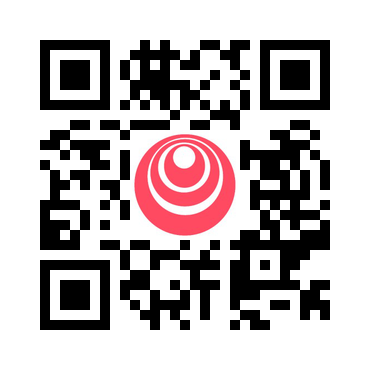

In [20]:
from IPython.display import Image, display

# Display image directly
Image('dl_qr_code.png')

### 4.3 Using multiple tools at once

Lastly, it's important to remember that LLMs can use multiple tools at and go through a sequence of tool calls to accomplish multiple things. Let's use your tools and examine the `response` to see what happens. You will use a complex prompt,

> Can you help me create a qr code that goes to www.deeplearning.com from the image dl_logo.jpg? Also write me a txt note with the current weather please.

This prompt requires a good amount of logic to understand what to call and when. For example, although you ask it to write a text note first and then describe the contents, the LLM will need that information first to pass it to the text note. If the LLM asked to use `write_txt_file` first, it would not have the information from `get_weather_from_ip`. This is a good example of the power of LLMs to parse natural language and use appropriate tools in the right order to accomplish a wide variety of tasks.

<div style="background-color: #ffe4e1; padding: 12px; border-radius: 6px; color: black;">

<h4>🔍 What to Notice:</h4>

<ul>
  <li>The LLM <b>automatically chooses</b> which tool to use based on the user request</li>
  <li><b>Parameters are inferred</b> from the user's message (like file names, content, URLs)</li>
  <li>Each tool <b>returns information</b> that the LLM incorporates into its response</li>
  <li><b>No-parameter tools</b> like weather and time are perfect for quick information requests</li>
  <li>The conversation feels <b>natural</b> despite complex operations happening behind the scenes</li>
</ul>

</div>

In [21]:
prompt = "Can you help me create a qr code that goes to www.deeplearning.com from the image dl_logo.jpg? Also write me a txt note with the current weather please."

response = client.chat.completions.create(
    model="openai:o4-mini",
    messages=[{"role": "user", "content": (
        prompt
    )}],
    tools=[
        get_weather_from_ip,
        get_current_time,
        write_txt_file,
        generate_qr_code
    ],
    max_turns=10
)

display_functions.pretty_print_chat_completion(response)

And just like that, you see from the tool sequence that it called the tools in the correct order to accomplish the task, but responded in the order that you requested it.

### Model Options

You can experiment with different OpenAI models when running these tool-calling workflows. Each model offers a different balance of capability, cost, and speed:

- **`openai:gpt-4o`** — optimized for reasoning and speed
- **`openai:gpt-4.1`** — strong reasoning performance, good for complex tasks
- **`openai:gpt-4.1-mini`** — lighter, faster, and cheaper than full GPT-4.1
- **`openai:gpt-3.5-turbo`** — efficient for simpler tasks and quick iterations

Choosing a model depends on your goals:
- Use smaller models for fast, low-cost prototyping
- Switch to stronger models when tasks require better reasoning or multi-step orchestration


### Final Takeaways

- Tool calling lets LLMs go beyond text generation—they can now use functions as part of their reasoning.
- Clear, well-documented functions (with precise docstrings) help the model know when and how to use each tool.
- AISuite handles the complexity of translating python functions into tool schemas and orchestrating multi-step workflows.
- Choosing the right model matters: smaller models are faster and cheaper for simple tasks, while stronger models are better for reasoning-heavy workflows.
- Watching the conversation flow (prompts, tool calls, results, final response) is essential for debugging and improving agentic behaviors.

With these elements in place, you now have the foundation to design agents that combine LLM reasoning with external tools to complete more complex tasks.


<div style="border:1px solid #22c55e; border-left:6px solid #16a34a; background:#dcfce7; border-radius:6px; padding:14px 16px; color:#064e3b; font-family:system-ui,-apple-system,Segoe UI,Roboto,Ubuntu,Cantarell,Noto Sans,sans-serif;">

🎉 <strong>Congratulations!</strong>

You’ve completed the lab on **turning functions into tools** with AISuite.  
Along the way, <strong>you</strong> exposed Python functions as tools, let the LLM choose and call them, and inspected multi-step tool orchestration.

With these skills, <strong>you</strong> can design agentic workflows that combine LLM reasoning with real actions—reliable, auditable, and easy to extend. 🌟

</div>
